# Additive Holt-Winter's model to account for trend and seasonality

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import importlib
import BuildTsModel
importlib.reload(BuildTsModel)
from BuildTsModel import (
    forecast_holt_winters, plot_forecast, evaluate_forecast, residcheck, calculate_pi_difference
)
# set plot style to ggplot2
plt.style.use('ggplot')
# maximize the size of the labels, ticks, and figures
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
# legend settings
plt.rcParams['legend.fontsize'] = 10

In [16]:
# import the training and testing data
train = pd.read_csv('train.csv', index_col=0, parse_dates=True)
train = train.squeeze()
train.index.freq = 'MS'
test = pd.read_csv('test.csv', index_col=0, parse_dates=True)
test = test.squeeze()
test.index.freq = 'MS'

There are three types of Exponential Smoothing Methods commonly used in time series analysis:

1. Single Exponential Smoothing: This method considers the level component (alpha) and is suitable for data without a trend or seasonality.

2. Double Exponential Smoothing: In addition to the level component, this method incorporates the trend component (beta). It is useful when there is a trend present in the data.

3. Triple Exponential Smoothing or Holt-Winters Method: This advanced technique captures three components - level (alpha), trend (beta), and seasonality (gamma) - making it suitable for time series data with both trend and seasonality. It can be applied to both additive and multiplicative series.

Considering that our data exhibits both trend and seasonality, the optimal model for such time series data is Triple Exponential Smoothing, also known as Winter's model or Holt-Winter's model.

In [17]:
# fit the Holt-Winters model with additive trend and seasonality
hw_model_dev = ExponentialSmoothing(train,
                                trend='add',
                                seasonal='add',
                                damped_trend=True,                                       
                                seasonal_periods=12).fit(method = 'L-BFGS-B')

In [18]:
# remove finaancila criis and covid
print(hw_model_dev.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:             sales_amount   No. Observations:                  352
Model:             ExponentialSmoothing   SSE                          49958.769
Optimized:                         True   AIC                           1778.273
Trend:                         Additive   BIC                           1843.955
Seasonal:                      Additive   AICC                          1780.563
Seasonal Periods:                    12   Date:                 Thu, 07 Nov 2024
Box-Cox:                          False   Time:                         01:15:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4746224                alpha                 True
smoothing_trend          

**Smoothing Level (α)**: This parameter, also known as alpha, represents the smoothing factor for the level component in the exponential smoothing model. It controls the weight given to the most recent observation in estimating the level. The value `0.47` suggests that the model puts more emphasis on recent data points and assigns less weight to past observations, which is useful in this case as the recent observations are heavily impacted by the wave of COVID-19 and serve as significant indicators for understanding the next values.

**Smoothing Trend (β)**: This parameter, also known as beta, determines the smoothing factor for the trend component in the exponential smoothing model. It governs the weight assigned to the most recent trend estimate. 

**Smoothing Seasonal (γ)**: This parameter, also known as gamma, represents the smoothing factor for the seasonal component in the exponential smoothing model. It controls the weight assigned to the seasonal pattern in the data. 

The value `0` for trend and seasonal parameters indicates that the model uses the initial values, which are seasonal indices, and the initial slope of the trend, which is 1.33. This slope will dampen over time by 0.995, which is consistent with the data. If we visually check the data, we will see that the trend is not actually linear but slightly deviates as the level of the series increases.


# Residuals Diagnostics $e_t$
When it comes to forecasting, there are several assumptions or conditions that are commonly considered for the residuals:

1. **Constant Mean  :** The residuals should have a constant mean of zero. This means that, on average, the model's predictions are unbiased. By assuming a zero mean for the residuals or forecast errors, we imply that our model tends to both overestimate and underestimate the target variable at different points in time. However, the key point is that, on average, our predictions should be centered around the actual value $y_t$. This means that over a large number of forecasts, the positive and negative errors should balance out, resulting in a mean error close to zero. In other words, the assumption of a zero mean suggests that our model is not consistently biased in one direction and is making accurate predictions on average.

2. **Constant Variance $\sigma$ :** The residuals should exhibit constant variance across different levels of the predicted values. This assumption is known as homoscedasticity and implies that the spread of the residuals is consistent.

3. **Normality ~ $\mathcal{N}(\mu, \sigma^2)$ :** The residuals should follow a normal distribution. This assumption allows for the use of statistical tests and confidence intervals that rely on the normality assumption. Non-normality of residuals may suggest that the model is not adequately capturing the underlying patterns or that there are unaccounted factors affecting the data.

4. **Absence of Autocorrelation:** The residuals should not exhibit any systematic patterns or correlations over time. This condition is important, especially in time series forecasting, as it ensures that there is no information left in the residuals that could be used to improve the model's predictions.

** Mean of the residuals:  0.43

** Ljung Box Test, p-value: 0.072 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.047 (<0.05, Stationary)


(<Axes: >,
 <Axes: title={'center': 'Autocorrelation'}>,
 <Axes: ylabel='Density'>)

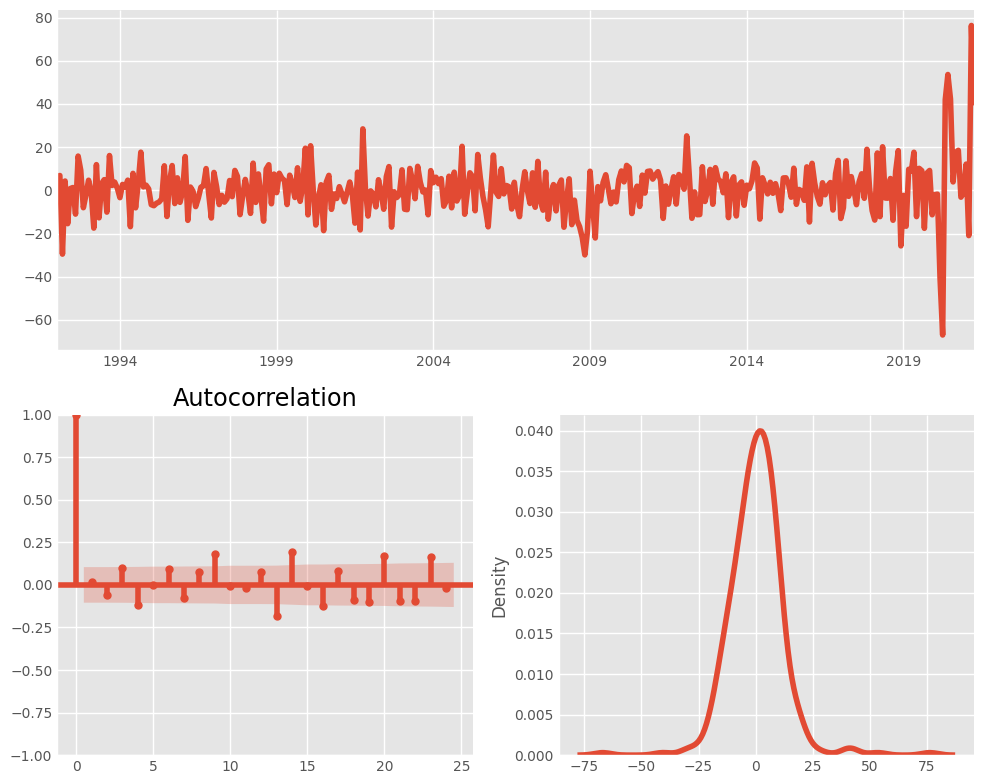

In [19]:
residcheck(hw_model_dev.resid, 24)

It is important to distinguish between `Confidence Interval (CI)` and `Predicted Interval (PI)`. 
**Confidence Interval (CI):** It estimates the range within which the true population parameter (e.g., mean, regression coefficient) is likely to fall with a specified level of confidence. CI reflects the uncertainty associated with estimating the model parameters.

**Prediction Interval (PI):** It estimates the range within which an individual observation or future value is likely to fall with a specified level of confidence. PI accounts for the uncertainty in both estimating the model parameters and the inherent randomness of future observations.


In summary, a confidence intervals focus on the mean or population parameter, while prediction intervals consider both the mean and the variability around individual observations. Therefore, we wil be using here PI as it is more relevant for understanding the uncertainty around individual forecasts

$ETS(A,A_d,A)$
$$\sigma^2_h = \sigma^2 \left[1 + \alpha^2(h-1) + \gamma k(2\alpha + \gamma) + \frac{\beta\phi h \left\{2\alpha(1 - \phi) + \beta\phi\right\}}{(1 - \phi)^2} - \frac{\beta\phi(1 - \phi^h)\left\{2\alpha(1 - \phi^2) + \beta\phi(1 + 2\phi - \phi^h)\right\}}{(1 - \phi)^2 (1 - \phi^2)} + \frac{2\beta\gamma\phi\left\{k(1 - \phi^m) - \phi^m(1 - \phi^{mk})\right\}}{(1 - \phi)(1 - \phi^m)}\right]$$

$ETS(A,A_d,A)$ is a state space model for time series data. The model has three components: the error component (A), the trend dampened component (A_d), and the seasonal component (A). The model is used to forecast future values of a time series based on its past values. 

The equation shown is used to calculate the variance of the forecast errors for the $ETS(A,A_d,A)$ model. The equation takes in several parameters, including the smoothing parameters (alpha, beta, gamma, and phi), the forecast horizon (h), and the number of seasons in a year (m). 

The equation is broken down into several components, each of which represents a different aspect of the model. The first component represents the variance of the errors in the data. The second component represents the variance of the trend component. The third component represents the variance of the seasonal component. The fourth component represents the covariance between the trend and seasonal components. The fifth component represents the covariance between the errors and the seasonal component. 

The equation is used to calculate the variance of the forecast errors, which is a measure of how accurate the model's forecasts are likely to be. A lower variance indicates that the model's forecasts are likely to be more accurate.


In [20]:
# make predictions for the next 24 months to evaluate the model (development phase)
hw_forecast_dev= forecast_holt_winters(hw_model_dev, horizon =41, seasonal_period=12)
print(hw_forecast_dev.head())
print(hw_forecast_dev.tail())

            forecast_mean  forecast_se  lower_ci_0.95  upper_ci_0.95
2021-05-01     661.246697    11.913367     637.816134     684.677259
2021-06-01     648.913204    13.187115     622.977503     674.848904
2021-07-01     647.613354    14.348230     619.394037     675.832670
2021-08-01     657.201983    15.422172     626.870496     687.533470
2021-09-01     624.084543    16.426048     591.778685     656.390400
            forecast_mean  forecast_se  lower_ci_0.95  upper_ci_0.95
2024-05-01     669.098659    35.957043     598.380305     739.817014
2024-06-01     656.725906    36.398910     585.138512     728.313300
2024-07-01     655.386993    36.835476     582.940983     727.833002
2024-08-01     664.936754    37.266929     591.642187     738.231321
2024-09-01     631.780640    37.693443     557.647227     705.914052


In [21]:
evaluate_forecast('Holt-Winters Model', test, hw_forecast_dev['forecast_mean'])

{'Model': 'Holt-Winters Model',
 'MAE': 22.6251,
 'RMSE': 26.1382,
 'MAPE': 3.6837}

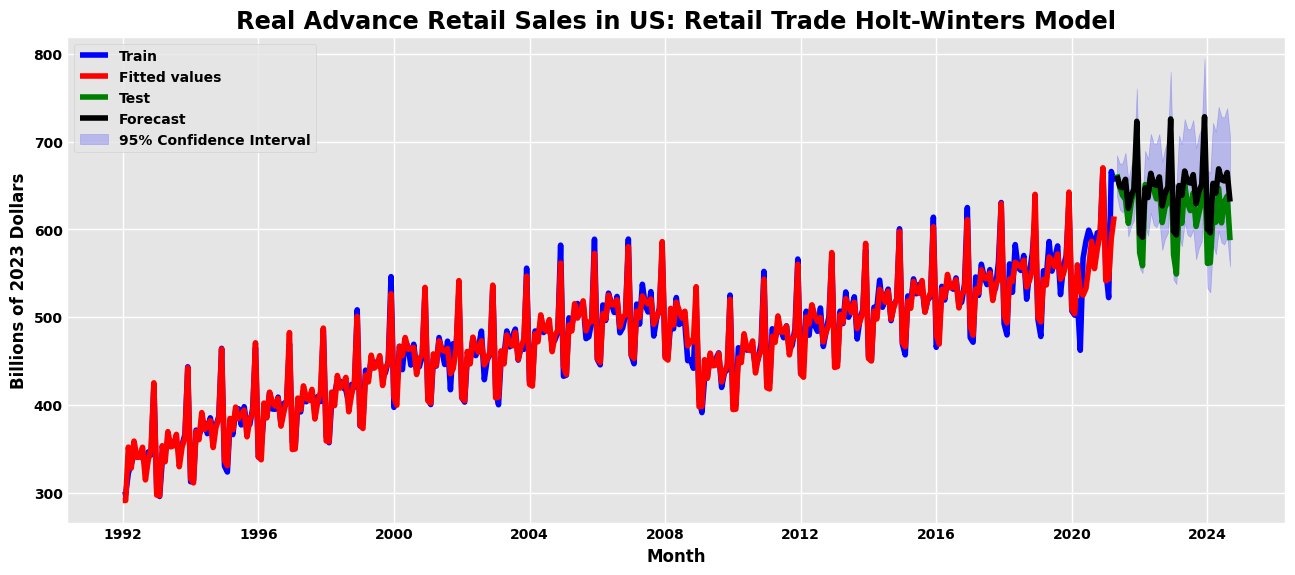

In [22]:
plot_forecast(train, test,hw_model_dev.fittedvalues, hw_forecast_dev, 'Holt-Winters Model', get_conf_int=True)

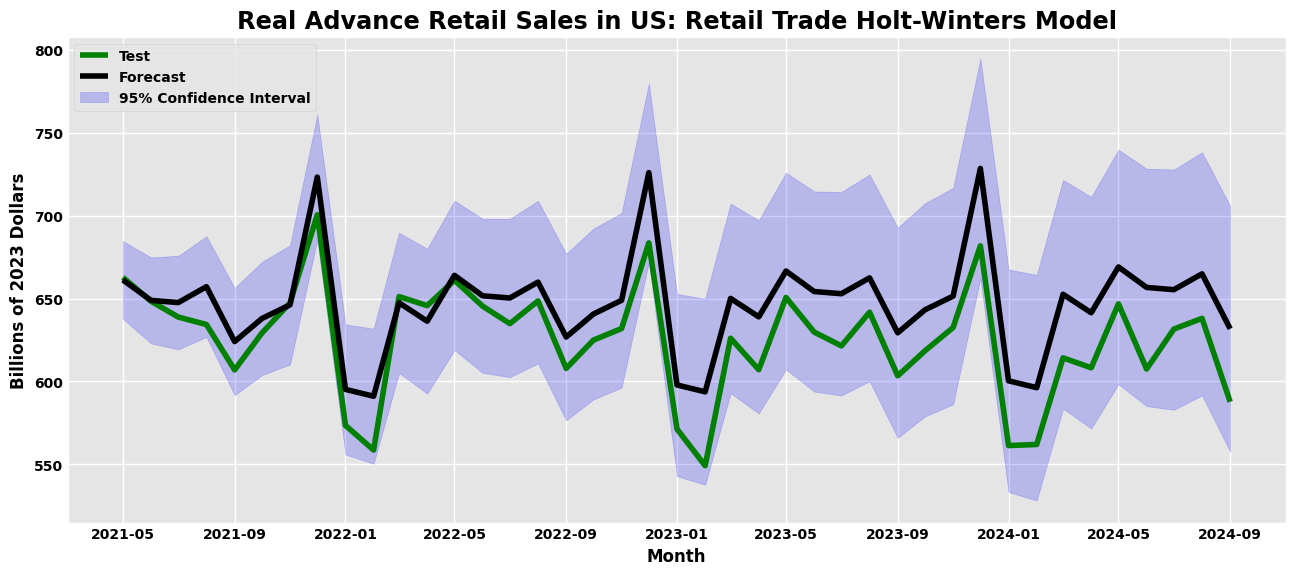

In [23]:
plot_forecast(test=test, forecasted_values=hw_forecast_dev, model_name= 'Holt-Winters Model', 
              get_conf_int=True, only_forecast_period = True, legend_loc='upper left')

In [24]:
calculate_pi_difference(test, hw_forecast_dev.iloc[:,2:4]) 

{'coverage': 1.0,
 'coverage_description': 'The proportion of true values within the confidence interval.',
 'ci_width': 4351.151,
 'ci_width_description': 'The width of the confidence interval, which indicates the uncertainty of the forecast.'}

# Get predictions for the entire data

In [25]:
# combine the training and testing data
entire_data = pd.concat([train, test], axis=0)

In [26]:
# fit the Holt-Winters model with additive trend and seasonality
hw_model = ExponentialSmoothing(entire_data,
                                trend='add',
                                seasonal='add',
                                damped_trend=True,                                       
                                seasonal_periods=12).fit(method = 'L-BFGS-B')

# make predictions for the next 24 months
hw_forecast= forecast_holt_winters(hw_model, horizon =24, seasonal_period=12)
print(hw_forecast.head())
print(hw_forecast.tail())

            forecast_mean  forecast_se  lower_ci_0.95  upper_ci_0.95
2024-10-01     609.772658    13.045988     584.123800     635.421515
2024-11-01     620.296883    14.154612     592.468433     648.125333
2024-12-01     686.657142    15.182499     656.807830     716.506453
2025-01-01     564.220450    16.145077     532.478677     595.962222
2025-02-01     556.824270    17.053409     523.296687     590.351854
            forecast_mean  forecast_se  lower_ci_0.95  upper_ci_0.95
2026-05-01     646.468723    27.260728     592.873202     700.064244
2026-06-01     626.273907    27.808318     571.601806     680.946008
2026-07-01     627.032601    28.345331     571.304714     682.760488
2026-08-01     634.753897    28.872357     577.989858     691.517936
2026-09-01     597.434922    29.389934     539.653308     655.216535


In [27]:
# save the train, test, entire_data, hw_forecast_dev, and hw_forecast to csv files
train.to_csv('train.csv')
test.to_csv('test.csv')
entire_data.to_csv('entire_data.csv')
hw_forecast_dev.to_csv('hw_forecast_dev.csv')
hw_forecast.to_csv('hw_forecast.csv')

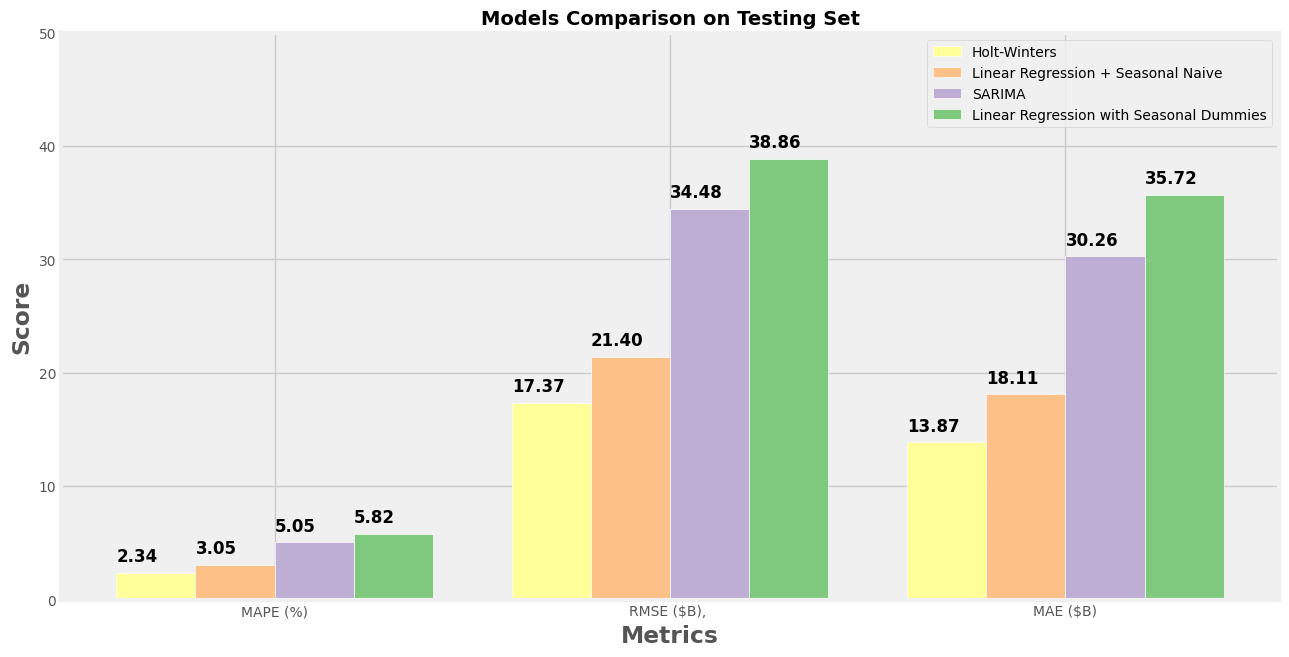

In [28]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('fivethirtyeight')

# Initialize figure with one plot
fig, ax1 = plt.subplots(1, 1)
# fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_size_inches(14, 7)
fig.set_facecolor('white')

# Set bar size
barWidth = 0.2

hw_score = [2.34, 17.37, 13.87]
lrsn_score = [3.05, 21.4, 18.11]
sar_score = [5.05, 34.48, 30.26]
lrsd_score = [5.82, 38.86, 35.72]



# Set position of bars on X axis
r1 = np.arange(len(hw_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]



# Make the plot
ax1.bar(r1, hw_score, width=barWidth, edgecolor='white', label='Holt-Winters', color="#ffff99")
ax1.bar(r2, lrsn_score, width=barWidth, edgecolor='white', label='Linear Regression + Seasonal Naive', color="#fdc086")
ax1.bar(r3, sar_score, width=barWidth, edgecolor='white', label='SARIMA', color="#beaed4")
ax1.bar(r4, lrsd_score, width=barWidth, edgecolor='white', label='Linear Regression with Seasonal Dummies', color="#7fc97f")



# Add scores to the top of each bar
for i, v in enumerate(hw_score):
    ax1.text(i - 0.1, v + 1, f"{v:.2f}", color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(lrsn_score):
    ax1.text(i + barWidth - 0.1, v + 1, f"{v:.2f}", color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(sar_score):
    ax1.text(i + 2*barWidth - 0.1, v + 1, f"{v:.2f}", color='black', fontweight='bold', fontsize=12)
for i, v in enumerate(lrsd_score):
    ax1.text(i + 3*barWidth - 0.1, v + 1, f"{v:.2f}", color='black', fontweight='bold', fontsize=12)

# Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
#ADD R SQUARED SCORE BUT THE THE 2 SHOULD BE RAISED  TOTHE POWER
#7fc97f

labels = ['MAPE (%)', 'RMSE ($B), ', 'MAE ($B)']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(hw_score))])
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 50)

# Create legend & title
ax1.set_title('Models Comparison on Testing Set', fontsize=14, fontweight='bold')
ax1.legend()

# Display the plot
plt.show()
